In [1]:
import argparse
import random, pickle
import json, os
import numpy as np
import pandas as pd
from itertools import combinations
import networkx as nx
from scipy.stats import norm, logistic

In [2]:
from csl.graph.SHD import SHD
from csl.utils.DAG2CPDAG import dag2cpdag
from csl.utils.TXT2GeneralGraph import dagadjmat2generalgraph
from csl.search.ConstraintBased.PC import pc
from csl.search.ScoreBased.GES import ges
from csl.utils import cit

In [3]:
import warnings
import igraph as ig
import magic
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pygraphviz

In [4]:
from scipy.stats import nbinom

In [5]:
warnings.filterwarnings("ignore")

In [6]:
# imported funcs: https://github.com/MarkDana/scRNA-Causal-Dropout/blob/main/main.py
def sample_linear_weighted_adjmat(adjmat_binary, linear_weight_ranges):
    range_ids_flatten = np.random.randint(0, len(linear_weight_ranges), size=adjmat_binary.size)
    weight_mask = np.array([np.random.uniform(*linear_weight_ranges[range_id]) for range_id in range_ids_flatten]).reshape(adjmat_binary.shape)
    return adjmat_binary * weight_mask
def encode_ijS(i, j, S):
    less, more = min(i, j), max(i, j)
    return f'{less};{more}|{".".join(map(str, sorted(S)))}'
def decode_ijS(ijS):
    ijstr, Sstr = ijS.split('|')
    i, j = map(int, ijstr.split(';'))
    S = set(map(int, Sstr.split('.'))) if Sstr != '' else set()
    return i, j, S
rand_funcs = {
    'gaussian': np.random.normal,
    'uniform': np.random.uniform,
    'laplace': np.random.laplace,
    'exponential': np.random.exponential,
}


class DAG_Simulator(object):
    def __init__(self,
                 n_nodes=10,  # （int) number of nodes
                 graph_type='ER', # (str) 'ER', 'SF'
                 avg_degree=2,  # (float) average degree = (sum_in_degree + sum_out_degree) / n_nodes = 2 * n_edges / n_nodes
                 linear_weight_ranges=((-1, -0.25), (0.25, 1)), # (tuple) range of linear weights. uniformly sampled from
                 load_dir=None,  # (str Pathlike) load the presampled weighted adjacency matrix, noise params, and d-separation oracles
                 save_dir=None,  # (str Pathlike) save the generated graph weights and noise params
                 ):
        # graph structure and edges weights
        if load_dir is not None:
            self.adjmat_weighted = np.load(os.path.join(load_dir, 'adjmat_weighted.npy'))
            self.n_nodes = self.adjmat_weighted.shape[0]
            self.adjmat_binary = (~np.isclose(self.adjmat_weighted, 0)).astype(int)
            self.edgeslist = list(zip(*np.where(self.adjmat_binary.T)))
        else:
            self.n_nodes = n_nodes
            assert graph_type in ['ER', 'SF']
            self.edgeslist = list(random.sample(list(combinations(range(self.n_nodes), 2)),
                                min(int(round(self.n_nodes * avg_degree / 2)), self.n_nodes * (self.n_nodes - 1) // 2))) \
                                    if graph_type == 'ER' else \
                             list(zip(*np.where(np.array(ig.Graph.Barabasi(     # note: int(round(avg_degree / 2)) might be too coarse for avg_degree=1,2,3,4,5,6. no SF for now.
                                 n=self.n_nodes, m=int(round(avg_degree / 2)), directed=True).get_adjacency().data).T))) #outpref=True for ig.Graph.Barabasi?
            self.edgesarray = np.array(self.edgeslist).reshape(-1, 2)
            self.adjmat_binary = np.zeros((self.n_nodes, self.n_nodes), dtype=int)
            self.adjmat_binary[self.edgesarray[:, 1], self.edgesarray[:, 0]] = 1
            self.adjmat_weighted = sample_linear_weighted_adjmat(self.adjmat_binary, linear_weight_ranges)
        self.parents = {x: np.where(self.adjmat_binary[x])[0] for x in range(self.n_nodes)}
        self.children = {x: np.where(self.adjmat_binary[:, x])[0] for x in range(self.n_nodes)}
        self.nxgraph = nx.DiGraph(self.adjmat_binary.T)

        # d-separation oracles
        if load_dir is not None:
            with open(os.path.join(load_dir, 'd_separation_oracles.json'), 'r') as fin:
                self.d_separation_oracles = json.load(fin)
        else:
            self.max_cond_size = min(3, n_nodes - 2)
            self.max_num_tests_per_class = 50   # i.e., need to do 2 * (1 + self.max_cond_size) * self.max_num_tests_per_class tests
            self.d_separation_oracles = {cond_size: {True: [], False: []} for cond_size in range(self.max_cond_size + 1)}
            all_XY_cond_candidates = [(x, y, S) for x in range(n_nodes)
                                                for y in range(x + 1, n_nodes)
                                                for cond_size in range(self.max_cond_size + 1)
                                                for S in combinations(set(range(n_nodes)) - {x, y}, cond_size)]
            random.shuffle(all_XY_cond_candidates)
            for x, y, S in all_XY_cond_candidates:
                d_sep_enough, d_conn_enough = len(self.d_separation_oracles[len(S)][True]) >= self.max_num_tests_per_class, \
                                              len(self.d_separation_oracles[len(S)][False]) >= self.max_num_tests_per_class
                if d_sep_enough and d_conn_enough: continue
                is_d_sep = nx.d_separated(self.nxgraph, {x}, {y}, set(S))
                if (is_d_sep and not d_sep_enough) or (not is_d_sep and not d_conn_enough):
                    self.d_separation_oracles[len(S)][is_d_sep].append(encode_ijS(x, y, S))

        if save_dir is not None and load_dir is None:
            # save the params for further preloading
            os.makedirs(save_dir, exist_ok=True)
            np.save(os.path.join(save_dir, 'adjmat_weighted.npy'), self.adjmat_weighted)

            # draw the graph structure
            figwidth = self.n_nodes * 0.5 + 2
            plt.figure(figsize=(figwidth, figwidth))
            pos = graphviz_layout(self.nxgraph, prog='dot')
            nx.draw_networkx_nodes(self.nxgraph, pos=pos, node_color='lightblue')
            nx.draw_networkx_labels(self.nxgraph, pos=pos, font_size=8)
            nx.draw_networkx_edges(self.nxgraph, pos=pos)
            nx.draw_networkx_edge_labels(self.nxgraph, pos=pos, edge_labels={e: f'{self.adjmat_weighted[e[1], e[0]]:.2f}' for e in self.edgeslist})
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, 'graph.pdf'), bbox_inches='tight')
            plt.close()

            # save the d-separation examples for further comparison
            with open(os.path.join(save_dir, 'd_separation_oracles.json'), 'w') as f:
                json.dump(self.d_separation_oracles, f, indent=2)


In [7]:
# true expression simulation (no dropout)
def simulate_true_latent_data_Gaussian(dag,n_samples = 10000,exo_noise_params_range=((-1, 1), (1., 2.))):
    """
    main simulation function from Dai. et al.
    note that given the nature of np.random.normal(), the ground truth latent can be negative!
    """
    n_nodes = dag.n_nodes
    noise_params = np.random.uniform(*exo_noise_params_range,size=(dag.n_nodes, len(exo_noise_params_range)))
    
    Z =  np.zeros((n_samples, n_nodes))
    
    for i in list(nx.topological_sort(dag.nxgraph)):
        Z[:, i] = Z @ dag.adjmat_weighted[i] + np.random.normal(*noise_params[i], n_samples)
        
    return Z



def simulate_true_latent_data_NB(dag,n_samples = 10000,exo_noise_params_range=((5,6), (1., 2.)),dispersion = 2):
    """
    negative binomial simulation with causal structure equation model

    """
    n_nodes = dag.n_nodes
    n_genes = n_nodes
    adj_matrix = dag.adjmat_weighted
    noise_params = np.random.uniform(*exo_noise_params_range,size=(dag.n_nodes, len(exo_noise_params_range)))
    
    expression = np.zeros((n_samples, n_genes))
    NB_mean = np.zeros((n_samples, n_genes))
    p = np.zeros((n_samples, n_genes))
    
    for i in list(nx.topological_sort(dag.nxgraph)):
        
        # Compute baseline expression for all samples (add Gaussian noise)
        NB_mean[:, i] = NB_mean @ dag.adjmat_weighted[i] + np.random.normal(*noise_params[i], n_samples)
        NB_mean = np.maximum(NB_mean, 0) 
        
        # Convert mean to probability for negative binomial
        p[:,i] = dispersion/(dispersion+NB_mean[:,i])
        
        for j in range(n_samples):
            expression[j,i] = nbinom.rvs(dispersion, p[j,i], size=1)
        

    return expression

In [8]:
# dropout mask function
def get_CAR_dropout_mask(latent_data, dropout_param_1=0.4, dropout_param_2=0.7):
    # a simple model of dropout.
    # Example 3.2 and sec 5.1 in Saeed, Basil, et al. "Anchored causal inference in the presence of measurement error." 2020.
    # Pierson, Emma, and Christopher Yau. "ZIFA: Dimensionality reduction for zero-inflated single-cell gene expression analysis." 2015.
    
    # each gene gets a different dropout probability
    probs = np.random.uniform(dropout_param_1, dropout_param_2, size= latent_data.shape[1])
    #print(probs)
    mask =  1. - np.random.binomial(n=1, p=probs, size=(latent_data.shape[0], latent_data.shape[1]))
    dropout_data = latent_data*mask
    
    return dropout_data

def get_CAR_by_mean_Zi_dropout_mask(latent_data, base_dropout_min=0.4, base_dropout_max=0.7):
    # dropout rate determined by 
    mean_Z = np.mean(latent_data, axis=0)
    
    normalized_gene_means = (mean_Z - np.min(mean_Z)) / (np.max(mean_Z) - np.min(mean_Z))
    
    # Adjust dropout ranges based on gene expression
    # Lower dropout rate for higher expression
    dropout_min = base_dropout_min + (1 - normalized_gene_means) * (base_dropout_max - base_dropout_min)
    dropout_max = base_dropout_max - (1 - normalized_gene_means) * (base_dropout_max - base_dropout_min) * 0.5

    # Generate dropout probabilities from the adjusted ranges for each gene
    probs = np.random.uniform(dropout_min, dropout_max)
    #print(probs)
    
    # Generate the dropout mask
    mask = 1. - np.random.binomial(n=1, p=probs, size=latent_data.shape)
    
    # Apply the dropout mask to the latent data
    dropout_data = latent_data * mask
    
    return dropout_data

def calculate_dropout_rate(latent_data, dropout_data):
    # Boolean mask of non-zero entries in latent_data
    non_zero_mask = latent_data != 0
    
    # Total number of non-zero entries in latent_data
    total_non_zero = np.sum(non_zero_mask)
    
    # Boolean mask of entries that are zero in dropout_data but non-zero in latent_data
    dropout_events = (dropout_data == 0) & non_zero_mask
    
    # Total number of dropout events
    total_dropout_events = np.sum(dropout_events)
    
    # Calculate the dropout rate
    dropout_rate = total_dropout_events / total_non_zero if total_non_zero > 0 else 0
    
    return dropout_rate

In [9]:
# test functions
def pc_manual_res(simu_data,dag,method,pval_alpha = 0.05):
    tester = cit.CIT(simu_data, method=method, cache_path=None,max_sample_size=200)
    cg = pc(simu_data, pval_alpha, tester, verbose=False, show_progress=False)
    true_cpdag_generalgraph = dag2cpdag(dagadjmat2generalgraph(dag.adjmat_binary))
    cpdag_shd = int(SHD(true_cpdag_generalgraph, cg.G).get_shd())
    
    skel_edges_true = {(i, j) if i < j else (j, i) for (i, j) in dag.edgeslist}
    skel_edges_estm = {(i, j) if i < j else (j, i) for (i, j) in list(zip(*np.where(cg.G.graph.T != 0)))}
    

    try:
        skel_true_positive_num = len(skel_edges_true.intersection(skel_edges_estm))
        skel_precision = skel_true_positive_num / len(skel_edges_estm)
        skel_recall = skel_true_positive_num / len(skel_edges_true)
        skel_f1 = 2 * skel_precision * skel_recall / (skel_precision + skel_recall)
    except ZeroDivisionError:
        skel_f1 = 0.
    
    return cpdag_shd,skel_f1

In [10]:
# performance evaluation function
def get_performance_table(dag,Z,pval_alpha = 0.05,degree = 0, exo_noise_mu = 0,rep = 0):
    """
    impose dropout event and get pc results for both original and dropout data
    """
    
    performance_table = pd.DataFrame(columns= ['node', 'degree', 'data_type', 'dropout_rate', 'test_method', 'SHD', 'F1','exo_noise_mu','rep'])

    shd_fisherz,f1_fisherz = pc_manual_res(Z,dag,'fisherz',pval_alpha)
    new_data1 = {
        'node': dag.n_nodes,
        'degree': degree, 
        'data_type': 'Oracle',
        'dropout_rate': 0,
        'test_method': 'fisherz',
        'SHD': shd_fisherz,
        'F1':f1_fisherz,
        'exo_noise_mu': exo_noise_mu,
        'rep':rep
    }
    
    
    shd_zerodel,f1_zerodel = pc_manual_res(Z,dag,'zerodel_fisherz',pval_alpha)
    new_data2 = {
        'node': dag.n_nodes,
        'degree': degree,
        'data_type': 'Oracle',
        'dropout_rate': 0,
        'test_method': 'zerodel_fisherz',
        'SHD': shd_zerodel,
        'F1':f1_zerodel,
        'exo_noise_mu': exo_noise_mu,
        'rep':rep
    }
    
    performance_table = performance_table.append(new_data1, ignore_index=True)
    performance_table = performance_table.append(new_data2, ignore_index=True)
    
    
    dropout_dat1 = get_CAR_dropout_mask(Z,dropout_param_1=0.1,dropout_param_2=0.3)
    dropout_dat2 = get_CAR_dropout_mask(Z,dropout_param_1=0.3,dropout_param_2=0.5)
    dropout_dat3 = get_CAR_dropout_mask(Z,dropout_param_1=0.5,dropout_param_2=0.7)
    dropout_dat4 = get_CAR_by_mean_Zi_dropout_mask(Z,base_dropout_min=0.4, base_dropout_max=0.7)
    
    dropout_list = [dropout_dat1,dropout_dat2,dropout_dat3,dropout_dat4]

    
    for dat in dropout_list:
        
        droput_rate = calculate_dropout_rate(Z,dat)
        
        shd_fisherz,f1_fisherz = pc_manual_res(dat,dag,'fisherz',pval_alpha)
        new_data1 = {
        'node': dag.n_nodes,
        'degree': degree,
        'data_type': 'dropout',
        'dropout_rate': droput_rate,
        'test_method': 'fisherz',
        'SHD': shd_fisherz,
        'F1':f1_fisherz,
        'exo_noise_mu': exo_noise_mu,
        'rep':rep}
        
        shd_zerodel,f1_zerodel = pc_manual_res(dat,dag,'zerodel_fisherz',pval_alpha)
        new_data2 = {
            'node': dag.n_nodes,
            'degree': degree,
            'data_type': 'dropout',
            'dropout_rate': droput_rate,
            'test_method': 'zerodel_fisherz',
            'SHD': shd_zerodel,
            'F1':f1_zerodel,
            'exo_noise_mu': exo_noise_mu,
            'rep':rep
        }        

        
        performance_table = performance_table.append(new_data1, ignore_index=True)
        performance_table = performance_table.append(new_data2, ignore_index=True)
        
    return performance_table

## Step 1. Simulate DAGs

In [ ]:
!pwd

In [ ]:
NODENUMS = [3, 5, 10, 20]
DEGREES = lambda x: [1, 1.5] if x == 3 else ([1.5, 3] if x == 5 else [1, 2, 3, 4, 5])

In [ ]:
for nodenum in NODENUMS:
    for degree in DEGREES(nodenum):
        dag_dir = f'./project_dir/{nodenum}_nodes_{degree}_degree/'
        dag = DAG_Simulator(n_nodes=nodenum,  # （int) number of nodes
                    graph_type='ER',
                    avg_degree=degree,
                    save_dir=dag_dir)

In [ ]:
class PDF(object):
    def __init__(self, pdf, size=(200,200)):
        self.pdf = pdf
        self.size = size

    def _repr_html_(self):
        return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

    def _repr_latex_(self):
        return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [ ]:
# visualize simulated DAGs
PDF('./project_dir/3_nodes_1.5_degree/graph.pdf',size=(300,250))

In [ ]:
PDF('./project_dir/10_nodes_3_degree/graph.pdf',size=(500,500))

## Step 2. Simulate Gaussian Data (no negative value adjustment) + run PC

In [ ]:
# take one DAG for example
dag = DAG_Simulator(n_nodes=None,  
                    graph_type=None,
                    avg_degree=None,
                    load_dir='./project_dir/3_nodes_1.5_degree/')
Z = simulate_true_latent_data_Gaussian(dag)

In [ ]:
p = get_performance_table(dag,Z)

In [ ]:
p

In [ ]:
performance_table = pd.DataFrame(columns= ['node', 'degree', 'data_type', 'dropout_rate', 'test_method', 'SHD', 'F1','exo_noise_mu','rep'])

NODENUMS = [3, 5, 10, 20]
DEGREES = lambda x: [1, 1.5] if x == 3 else ([1.5, 3] if x == 5 else [1, 2, 3, 4, 5])

start_range = -1
end_range = 5
step = 1
for i in range(start_range, end_range, step):
    exo_noise_params_range = ((i, i+2), (1., 2.))
    # print(exo_noise_params_range)

for nodenum in NODENUMS:
    print(nodenum)
    for degree in DEGREES(nodenum):
        dag_dir = f'./project_dir/{nodenum}_nodes_{degree}_degree/'
        dag = DAG_Simulator(n_nodes=None,  
                            graph_type=None,
                            avg_degree=None,
                            load_dir=dag_dir)
        for rep in range(5):
            start_range = -1
            end_range = 5
            step = 1
            for i in range(start_range, end_range, step):
                exo_noise_params_range = ((i, i+2), (1., 2.))
                Z = simulate_true_latent_data_Gaussian(dag,n_samples = 10000,exo_noise_params_range = exo_noise_params_range)
                # print(exo_noise_params_range)
                exo_noise_mu = (exo_noise_params_range[0][0] + exo_noise_params_range[0][1]) / 2
                np.save(f'{dag_dir}/Z_Gaussian_exo_noise_mu_{exo_noise_mu}_rep_{rep}.npy', Z)

                p = get_performance_table(dag,Z,pval_alpha = 0.05,degree = degree, exo_noise_mu = exo_noise_mu,rep = rep)
                performance_table = performance_table.append(p,ignore_index=True)

In [ ]:
performance_table.to_csv('project_dir/Gaussian_raw_performance.txt',sep='\t')

## Step 3a. Simulate negative binomial data (unlog, fixed disperison = 2) + run PC

In [ ]:
performance_table = pd.DataFrame(columns= ['node', 'degree', 'data_type', 'dropout_rate', 'test_method', 'SHD', 'F1','exo_noise_mu','rep'])

NODENUMS = [3, 5, 10]
DEGREES = lambda x: [1, 1.5] if x == 3 else ([1.5, 3] if x == 5 else [1, 2, 3, 4, 5])

start_range = -1
end_range = 5
step = 1
for i in range(start_range, end_range, step):
    exo_noise_params_range = ((i, i+2), (1., 2.))
    # print(exo_noise_params_range)

for nodenum in NODENUMS:
    print(nodenum)
    for degree in DEGREES(nodenum):
        dag_dir = f'./project_dir/{nodenum}_nodes_{degree}_degree/'
        dag = DAG_Simulator(n_nodes=None,  
                            graph_type=None,
                            avg_degree=None,
                            load_dir=dag_dir)
        
        for rep in range(5):
            start_range = -1
            end_range = 5
            step = 1
            for i in range(start_range, end_range, step):
                exo_noise_params_range = ((i, i+2), (1., 2.))
                Z = simulate_true_latent_data_NB(dag,n_samples = 10000,exo_noise_params_range = exo_noise_params_range,dispersion = 2)
                exo_noise_mu = (exo_noise_params_range[0][0] + exo_noise_params_range[0][1]) / 2

                np.save(f'{dag_dir}/Z_NB_exo_noise_mu_{exo_noise_mu}_rep_{rep}.npy', Z)

                p = get_performance_table(dag,Z,pval_alpha = 0.05,degree = degree, exo_noise_mu = exo_noise_mu,rep = rep)
                performance_table = performance_table.append(p,ignore_index=True)

In [ ]:
performance_table.to_csv('project_dir/NB_raw_dispersion_2_performance.txt',sep='\t')

In [12]:
# add 20 nodes performance (SVD not converged when degree = 5, therefore we only report the results for degree 1:4)
performance_table = pd.DataFrame(columns= ['node', 'degree', 'data_type', 'dropout_rate', 'test_method', 'SHD', 'F1','exo_noise_mu','rep'])

NODENUMS = [20]
DEGREES = lambda x: [1, 1.5] if x == 3 else ([1.5, 3] if x == 5 else [1, 2, 3, 4, 5])

start_range = -1
end_range = 5
step = 1
for i in range(start_range, end_range, step):
    exo_noise_params_range = ((i, i+2), (1., 2.))
    # print(exo_noise_params_range)

for nodenum in NODENUMS:
    # print(nodenum)
    for degree in DEGREES(nodenum):
        print(degree)
        dag_dir = f'./project_dir/{nodenum}_nodes_{degree}_degree/'
        dag = DAG_Simulator(n_nodes=None,  
                            graph_type=None,
                            avg_degree=None,
                            load_dir=dag_dir)
        
        for rep in range(5):
            start_range = -1
            end_range = 5
            step = 1
            for i in range(start_range, end_range, step):
                exo_noise_params_range = ((i, i+2), (1., 2.))
                Z = simulate_true_latent_data_NB(dag,n_samples = 10000,exo_noise_params_range = exo_noise_params_range,dispersion = 2)
                exo_noise_mu = (exo_noise_params_range[0][0] + exo_noise_params_range[0][1]) / 2

                np.save(f'{dag_dir}/Z_NB_exo_noise_mu_{exo_noise_mu}_rep_{rep}.npy', Z)

                p = get_performance_table(dag,Z,pval_alpha = 0.05,degree = degree, exo_noise_mu = exo_noise_mu,rep = rep)
                performance_table = performance_table.append(p,ignore_index=True)

1
2
3
4
5


LinAlgError: SVD did not converge

In [13]:
performance_table

,node,degree,data_type,dropout_rate,test_method,SHD,F1,exo_noise_mu,rep
0,20,1,Oracle,0,fisherz,19,0.666667,0.0,0
1,20,1,Oracle,0,zerodel_fisherz,5,0.666667,0.0,0
2,20,1,dropout,0.195602,fisherz,19,0.689655,0.0,0
3,20,1,dropout,0.195602,zerodel_fisherz,8,0.533333,0.0,0
4,20,1,dropout,0.386055,fisherz,13,0.720000,0.0,0
...,...,...,...,...,...,...,...,...,...
1205,20,5,dropout,0.421358,zerodel_fisherz,50,0.000000,0.0,0
1206,20,5,dropout,0.573061,fisherz,62,0.694737,0.0,0
1207,20,5,dropout,0.573061,zerodel_fisherz,50,0.000000,0.0,0
1208,20,5,dropout,0.576181,fisherz,60,0.709677,0.0,0


In [14]:
performance_table.to_csv('project_dir/NB_raw_dispersion_2_performance_node20.txt',sep='\t')

In [ ]:
# take one DAG for example
dag = DAG_Simulator(n_nodes=None,  
                    graph_type=None,
                    avg_degree=None,
                    load_dir='./project_dir/3_nodes_1.5_degree/')
Z = simulate_true_latent_data_NB(dag)

In [ ]:
p = get_performance_table(dag,Z)

In [ ]:
p

## Step 3b. log transform simulated NB + run PC

In [14]:
performance_table = pd.DataFrame(columns= ['node', 'degree', 'data_type', 'dropout_rate', 'test_method', 'SHD', 'F1','exo_noise_mu','rep'])

NODENUMS = [3, 5, 10, 20]
DEGREES = lambda x: [1, 1.5] if x == 3 else ([1.5, 3] if x == 5 else [1, 2, 3, 4, 5])
for nodenum in NODENUMS:
    print(nodenum)
    for degree in DEGREES(nodenum):
        dag_dir = f'./project_dir/{nodenum}_nodes_{degree}_degree/'
        dag = DAG_Simulator(n_nodes=None,  
                            graph_type=None,
                            avg_degree=None,
                            load_dir=dag_dir)
           
        for rep in range(5):
            start_range = 2
            end_range = 5
            step = 1
            for i in range(start_range, end_range, step):
                exo_noise_params_range = ((i, i+2), (1., 2.))
                exo_noise_mu = (exo_noise_params_range[0][0] + exo_noise_params_range[0][1]) / 2
                Z = np.load(f'{dag_dir}/Z_NB_exo_noise_mu_{exo_noise_mu}_rep_{rep}.npy')
                Z = np.log(Z+1)
                p = get_performance_table(dag,Z,pval_alpha = 0.05,degree = degree, exo_noise_mu = exo_noise_mu,rep = rep)
                performance_table = performance_table.append(p,ignore_index=True)

3
5
10


In [15]:
performance_table.to_csv('project_dir/NB_log_dispersion_2_performance.txt',sep='\t')

## Step4. Apply to real scRNA data

In [11]:
import scanpy as sc
import pandas as pd
import numpy as np

In [14]:
adata = sc.read_h5ad("../dcdfg_perturbseq/SCP1064/ready/cocult/raw_unperturbed_adata.h5ad")

In [15]:
adata

AnnData object with n_obs × n_vars = 7556 × 15335
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs'

In [16]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

In [18]:
genes_of_interest = ['STAT1','JAK1','JAK2','IFNGR1','IFNGR2',
                     'PSMA3', 'PSMA1', 'PSMB1', 'B2M', 'PSMA7', 'PSMB8', # Antigen processing and presentation of exogenous peptide antigen via MHC class I
                     'CENPE', 'HLA-DMA', 'RACGAP1', 'KIF4A', 'HLA-DPB1', 'HLA-DRA', 'KIF23', 'KIF2C', 'HLA-DRB1', 'HLA-DPA1' #Antigen processing and presentation of exogenous peptide antigen via MHC class II
                     ]
adata_subset = adata[:, genes_of_interest]

In [21]:
adata_subset

View of AnnData object with n_obs × n_vars = 7556 × 21
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs'
    uns: 'log1p'
    layers: 'counts'

In [26]:
tester = cit.CIT(adata_subset.X.toarray(), method='fisherz', cache_path=None,
                           max_sample_size=200) # max_sample_size is used only for kci
cg = pc(adata_subset.X.toarray(), 0.05, tester, verbose=False, show_progress=False)

In [27]:
cg.to_nx_graph()

Green: undirected; Blue: directed; Red: bi-directed



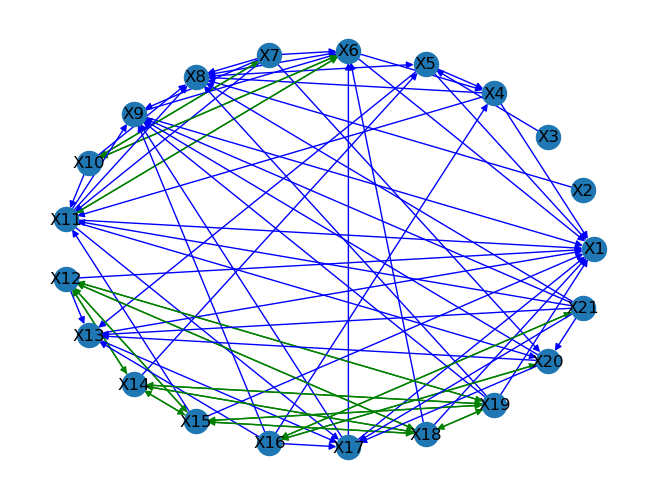

In [28]:
cg.draw_nx_graph()

In [30]:
tester2 = cit.CIT(adata_subset.X.toarray(), method='zerodel_fisherz', cache_path=None,
                           max_sample_size=200) # max_sample_size is used only for kci
cg2 = pc(adata_subset.X.toarray(), 0.05, tester2, verbose=False, show_progress=False)

In [31]:
cg2.to_nx_graph()

Green: undirected; Blue: directed; Red: bi-directed



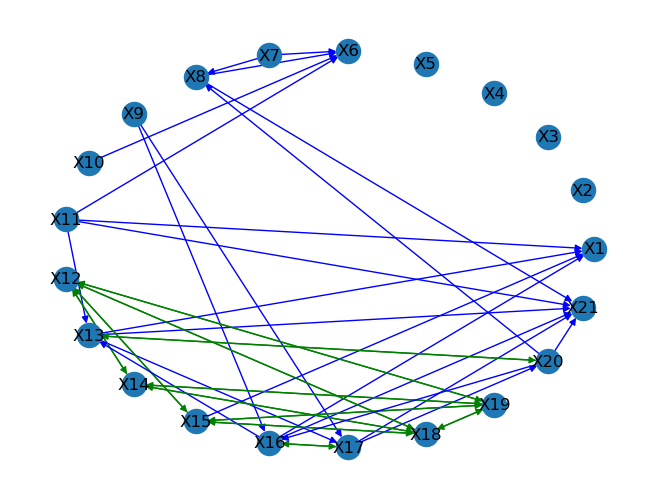

In [33]:
cg2.draw_nx_graph()